In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from dotenv import load_dotenv
import itertools

In [2]:
# env variables
load_dotenv()
# edit the environment file to your datafile
data_path = os.environ.get("data_path")

os.chdir(data_path)

ny = pd.read_csv('ny_interpolated.csv')
tx = pd.read_csv('tx_interpolated.csv')

In [152]:
max(ny.describe().loc['max'].values[2:])

20.955

In [60]:
multi_ny_weekday = pd.to_datetime(ny.reset_index()["date"], format= "%Y%M%d").dt.weekday
multi_ny_building = ny.reset_index()["dataid"]
multi_ny_building.index, multi_ny_weekday.index = ny.index, ny.index
multi_ny_temp = ny.copy()
multi_ny_temp["building"], multi_ny_temp["DOW"] = multi_ny_building, multi_ny_weekday
multi_ny_temp = multi_ny_temp.groupby(["building","DOW"])\
    .apply(lambda x: x / np.max(abs(x)))\
    .drop(["building", "DOW"], axis=1)
multi_ny_temp.head()

,dataid,date,0,1,2,3,4,5,6,7,...,86,87,88,89,90,91,92,93,94,95
0,1.0,0.999974,0.274656,0.201505,0.158127,0.318758,0.388597,0.594885,0.438753,0.683028,...,0.122958,0.282492,0.143149,0.143511,0.052399,0.075857,0.078901,0.046725,0.104708,0.067541
1,1.0,0.999974,0.075019,0.175159,0.244224,0.787194,0.319588,0.291757,0.703081,0.419753,...,0.180556,0.189671,0.181796,0.167541,0.050496,0.059728,0.079259,0.097894,0.066546,0.092231
2,1.0,0.999974,0.231579,0.280411,0.192308,0.184810,0.212736,0.285000,0.246334,0.272152,...,0.158534,0.111241,0.076549,0.074482,0.071542,0.075454,0.055905,0.066715,0.086096,0.087605
3,1.0,0.999974,0.094686,0.074886,0.098034,0.099075,0.071237,0.058658,0.233256,0.397115,...,0.337920,0.194431,0.547463,0.346020,0.338782,0.645701,0.395458,0.838480,0.773962,0.621495
4,1.0,0.999974,0.302054,0.486460,0.438272,0.349810,0.806625,0.176978,0.642578,0.381679,...,0.193653,0.140778,0.192687,0.116037,0.139790,0.124143,0.138882,0.154754,0.143122,0.145593


In [61]:
multi_ny_temp['dataid'] = multi_ny_building

In [62]:
multi_ny_temp[multi_ny_temp['dataid'] == 27]

,dataid,date,0,1,2,3,4,5,6,7,...,86,87,88,89,90,91,92,93,94,95
0,27,0.999974,0.274656,0.201505,0.158127,0.318758,0.388597,0.594885,0.438753,0.683028,...,0.122958,0.282492,0.143149,0.143511,0.052399,0.075857,0.078901,0.046725,0.104708,0.067541
1,27,0.999974,0.075019,0.175159,0.244224,0.787194,0.319588,0.291757,0.703081,0.419753,...,0.180556,0.189671,0.181796,0.167541,0.050496,0.059728,0.079259,0.097894,0.066546,0.092231
2,27,0.999974,0.231579,0.280411,0.192308,0.184810,0.212736,0.285000,0.246334,0.272152,...,0.158534,0.111241,0.076549,0.074482,0.071542,0.075454,0.055905,0.066715,0.086096,0.087605
3,27,0.999974,0.094686,0.074886,0.098034,0.099075,0.071237,0.058658,0.233256,0.397115,...,0.337920,0.194431,0.547463,0.346020,0.338782,0.645701,0.395458,0.838480,0.773962,0.621495
4,27,0.999974,0.302054,0.486460,0.438272,0.349810,0.806625,0.176978,0.642578,0.381679,...,0.193653,0.140778,0.192687,0.116037,0.139790,0.124143,0.138882,0.154754,0.143122,0.145593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,27,1.000000,0.359245,0.751451,0.483726,0.542776,0.751119,0.239329,0.876953,0.331425,...,0.212273,0.153254,0.189996,0.171269,0.122287,0.218413,0.107855,0.198936,0.135171,0.204199
179,27,1.000000,0.208222,0.210691,0.589744,0.276875,0.571744,0.375152,0.464608,0.561165,...,0.252745,0.275708,0.291584,0.167146,0.075147,0.121713,0.119083,0.138302,0.162721,0.086494
180,27,1.000000,0.123545,0.111891,0.129587,0.258376,0.190150,0.337674,0.359099,0.311111,...,0.794375,0.911232,0.729126,0.218076,0.052783,0.043931,0.177826,0.079055,0.059921,0.041477
181,27,1.000000,0.044628,0.084632,0.133680,0.129373,0.168042,0.153453,0.282851,0.181549,...,0.053642,0.046187,0.044909,0.051529,0.044280,0.048518,0.066268,0.060593,0.041191,0.044435


In [63]:
# multi_ny_weekday = pd.to_datetime(ny.reset_index()["date"], format= "%Y%M%d").dt.weekday
# multi_ny_building = ny.reset_index()["dataid"]
# multi_ny_building.index, multi_ny_weekday.index = ny.index, ny.index
# multi_ny_temp = ny.copy()
# multi_ny_temp["building"] = multi_ny_building
# multi_ny_temp = multi_ny_temp.groupby(["building"])\
#     .apply(lambda x: x / np.max(abs(x)))\
#     .drop(["building"], axis=1)
# multi_ny_temp.head()

In [64]:
multi_ny_temp[multi_ny_temp.columns[2:]]

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.274656,0.201505,0.158127,0.318758,0.388597,0.594885,0.438753,0.683028,0.611354,0.373126,...,0.122958,0.282492,0.143149,0.143511,0.052399,0.075857,0.078901,0.046725,0.104708,0.067541
1,0.075019,0.175159,0.244224,0.787194,0.319588,0.291757,0.703081,0.419753,0.236019,0.359270,...,0.180556,0.189671,0.181796,0.167541,0.050496,0.059728,0.079259,0.097894,0.066546,0.092231
2,0.231579,0.280411,0.192308,0.184810,0.212736,0.285000,0.246334,0.272152,0.175014,0.251032,...,0.158534,0.111241,0.076549,0.074482,0.071542,0.075454,0.055905,0.066715,0.086096,0.087605
3,0.094686,0.074886,0.098034,0.099075,0.071237,0.058658,0.233256,0.397115,0.203509,0.141503,...,0.337920,0.194431,0.547463,0.346020,0.338782,0.645701,0.395458,0.838480,0.773962,0.621495
4,0.302054,0.486460,0.438272,0.349810,0.806625,0.176978,0.642578,0.381679,0.402194,0.602535,...,0.193653,0.140778,0.192687,0.116037,0.139790,0.124143,0.138882,0.154754,0.143122,0.145593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4570,0.318223,0.320253,0.331471,0.548297,0.379359,0.347163,0.346226,0.344208,0.102502,0.086032,...,0.086028,0.078012,0.067139,0.066381,0.096081,0.211740,0.237384,0.295605,0.300286,0.300817
4571,0.297656,0.275973,0.301257,0.287591,0.301388,0.241259,0.228912,0.207784,0.209901,0.075658,...,0.306315,0.222292,0.218310,0.267059,0.290362,0.279640,0.289460,0.300027,0.338720,0.355613
4572,0.328278,0.382881,0.317698,0.226472,0.177640,0.164593,0.167315,0.167478,0.167368,0.186577,...,0.147406,0.177468,0.274517,0.283577,0.303336,0.262771,0.349977,0.336449,0.382027,0.356440
4573,0.354667,0.354896,0.359468,0.335157,0.164336,0.131431,0.111111,0.080326,0.095473,0.146713,...,0.120241,0.128814,0.133761,0.128083,0.108883,0.125263,0.153090,0.237126,0.289072,0.291650


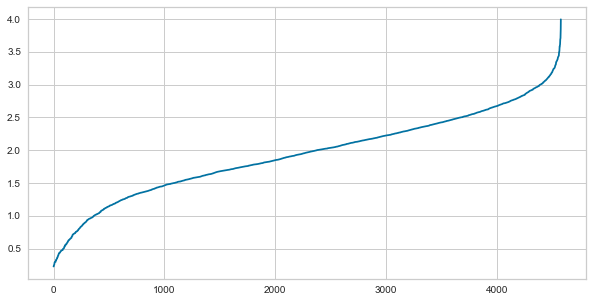

In [65]:
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(multi_ny_temp[multi_ny_temp.columns[2:]])
distances, idx = nn.kneighbors(multi_ny_temp[multi_ny_temp.columns[2:]])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [85]:
len(distances)

4575

In [66]:
db_ny = DBSCAN(eps=1, min_samples=6).fit(multi_ny_temp[multi_ny_temp.columns[2:]])
labels = db_ny.labels_# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(multi_ny_temp[multi_ny_temp.columns[2:]], labels))

Estimated number of clusters: 9
Estimated number of noise points: 4308
Silhouette Coefficient: -0.294


In [67]:
db_ny = DBSCAN(eps=.75, min_samples=6).fit(multi_ny_temp[multi_ny_temp.columns[2:]])
labels = db_ny.labels_# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(multi_ny_temp[multi_ny_temp.columns[2:]], labels))

Estimated number of clusters: 8
Estimated number of noise points: 4451
Silhouette Coefficient: -0.286


In [68]:
db_ny = DBSCAN(eps=2.5, min_samples=6).fit(multi_ny_temp[multi_ny_temp.columns[2:]])
labels = db_ny.labels_# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(multi_ny_temp[multi_ny_temp.columns[2:]], labels))

Estimated number of clusters: 3
Estimated number of noise points: 1010
Silhouette Coefficient: 0.045


In [69]:
len(labels[labels == 0])

3541

In [70]:
len(labels[labels == 1])

8

In [71]:
len(labels[labels == 2])

16

In [73]:
len(labels[labels == -1])

1010

In [74]:
multi_ny_temp['cluster'] = labels

<AxesSubplot:>

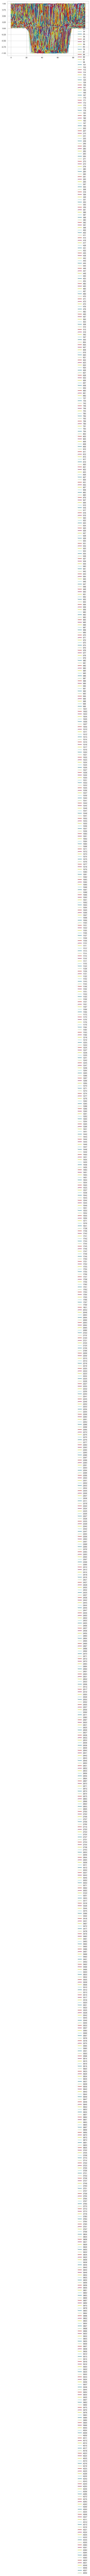

In [75]:
multi_ny_temp[multi_ny_temp['cluster'] == -1][multi_ny_temp.columns[2:-1]].T.plot(kind = 'line')

<AxesSubplot:>

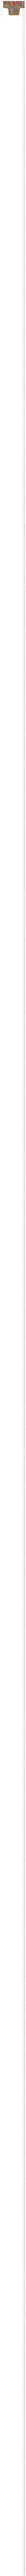

In [76]:
multi_ny_temp[multi_ny_temp['cluster'] == 0][multi_ny_temp.columns[2:-1]].T.plot(kind = 'line')

<AxesSubplot:>

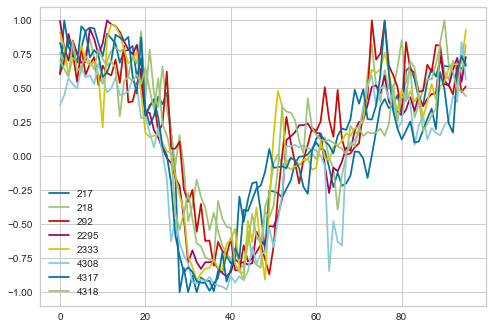

In [77]:
multi_ny_temp[multi_ny_temp['cluster'] == 1][multi_ny_temp.columns[2:-1]].T.plot(kind = 'line')

<AxesSubplot:>

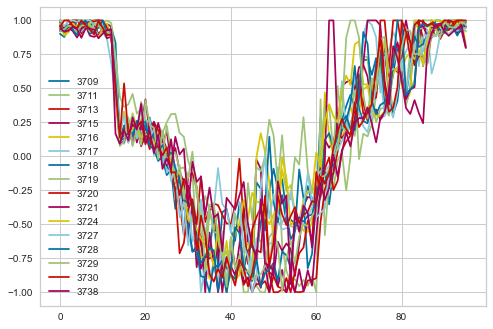

In [78]:
multi_ny_temp[multi_ny_temp['cluster'] == 2][multi_ny_temp.columns[2:-1]].T.plot(kind = 'line')

In [79]:
nycluster = multi_ny_temp.groupby(['cluster']).mean()

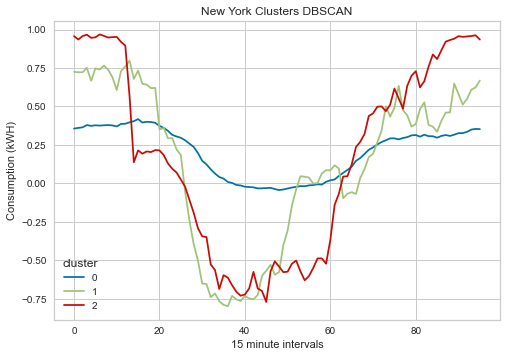

In [80]:
nycluster[nycluster.columns[2:]].iloc[1:].T.plot(kind = 'line')
plt.title('New York Clusters DBSCAN')
plt.xlabel('15 minute intervals')
plt.ylabel('Consumption (kWH)');

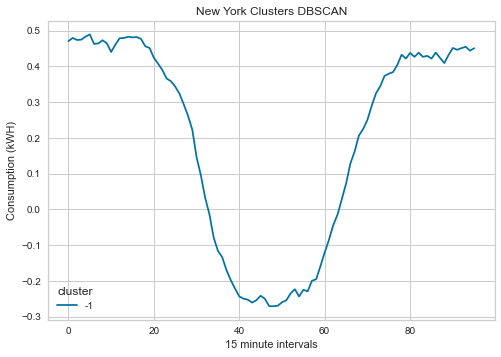

In [81]:
nycluster[nycluster.columns[2:]].iloc[:1].T.plot(kind = 'line')
plt.title('New York Clusters DBSCAN')
plt.xlabel('15 minute intervals')
plt.ylabel('Consumption (kWH)');

In [82]:
multi_ny_temp[multi_ny_temp['cluster'] == 2][multi_ny_temp.columns[2:-1]].T

,3709,3711,3713,3715,3716,3717,3718,3719,3720,3721,3724,3727,3728,3729,3730,3738
0,0.901435,0.964147,0.928502,0.971940,0.968900,0.919157,0.984012,1.000000,1.000000,0.920354,0.974843,1.000000,0.961160,0.920233,0.953754,0.942912
1,0.877980,0.940204,0.939379,0.915844,0.888733,0.935593,0.961108,1.000000,0.926014,0.935255,0.904560,0.958192,0.925331,0.935084,1.000000,0.915374
2,0.943451,0.959701,1.000000,0.957692,0.913485,0.942803,0.955721,1.000000,0.924447,0.947137,0.931250,0.990547,0.964758,0.961501,1.000000,0.926442
3,0.968566,0.973570,0.983291,1.000000,0.975442,0.942771,0.926958,1.000000,1.000000,0.921248,0.977415,1.000000,0.932640,0.953418,0.958841,0.952907
4,0.916344,0.935280,0.929134,0.960268,0.966151,0.929920,1.000000,1.000000,1.000000,0.874001,0.944471,0.989294,0.891396,0.920276,0.943269,0.935854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.947368,0.952315,0.996030,0.930222,0.888216,0.957499,1.000000,0.980198,0.930025,0.999010,0.950967,0.894907,0.964851,0.956824,1.000000,0.886846
92,0.945933,0.965184,0.953699,0.990741,0.936678,0.920300,1.000000,0.948483,0.957725,0.930669,1.000000,0.935687,0.949446,0.946150,0.986622,0.916179
93,0.996982,0.961990,0.923649,0.904851,0.990946,0.968780,1.000000,0.953664,1.000000,0.907329,1.000000,0.923041,0.888416,0.959841,1.000000,0.940299
94,0.983075,0.919145,0.947933,0.925439,0.951161,0.948207,1.000000,0.953740,0.958652,0.969488,1.000000,0.934480,0.944882,1.000000,1.000000,0.966862


In [100]:
def distortion_calc(clusters, centroid):
    ssum = 0
    for i in clusters:
        ssum += (i - centroid)**2
    return sum(ssum)

In [101]:
distortion_calc(multi_ny_temp[multi_ny_temp['cluster'] == 2][multi_ny_temp.columns[2:-1]].values,
                nycluster[nycluster.columns[2:]].iloc[3].T.values)

56.67939148549614

In [102]:
total_distortion = 0
no_noise = 0
for i in range(-1,3):
    if i == 1:
        total_distortion += distortion_calc(multi_ny_temp[multi_ny_temp['cluster'] == i][multi_ny_temp.columns[2:-1]].values,
                nycluster[nycluster.columns[2:]].iloc[i+1].T.values)
    else:
        total_distortion += distortion_calc(multi_ny_temp[multi_ny_temp['cluster'] == i][multi_ny_temp.columns[2:-1]].values,
                nycluster[nycluster.columns[2:]].iloc[i+1].T.values)
        no_noise += distortion_calc(multi_ny_temp[multi_ny_temp['cluster'] == i][multi_ny_temp.columns[2:-1]].values,
                nycluster[nycluster.columns[2:]].iloc[i+1].T.values)

In [103]:
no_noise

58645.205452479684

In [104]:
total_distortion

58671.48538704813

It doesn't make sense to use distortion as a metric for DBScan. It doesn't minimize based off distortion but rather collapses based off of epsilon values. Here something like PCA would improve the results of the clustering, as there would be less variables that would influence whether it belongs to a cluster or not.

In [105]:
from sklearn.decomposition import PCA

In [153]:
pca = PCA(n_components=10)
pca.fit(multi_ny_temp[multi_ny_temp.columns[2:]])
print(sum(pca.explained_variance_ratio_))

0.7915400431620463


In [124]:
ninety = pca.transform(multi_ny_temp[multi_ny_temp.columns[2:]])

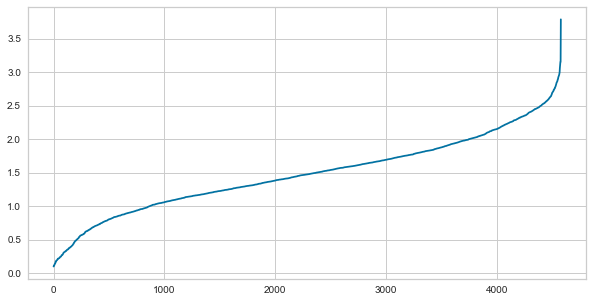

In [125]:
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(ninety)
distances, idx = nn.kneighbors(ninety)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [126]:
db_ny = DBSCAN(eps=2.5, min_samples=6).fit(ninety)
labels = db_ny.labels_# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(ninety, labels))

Estimated number of clusters: 2
Estimated number of noise points: 224
Silhouette Coefficient: 0.108


In [133]:
pcaed = pd.DataFrame(pca.inverse_transform(ninety))
pcaed['cluster'] = labels

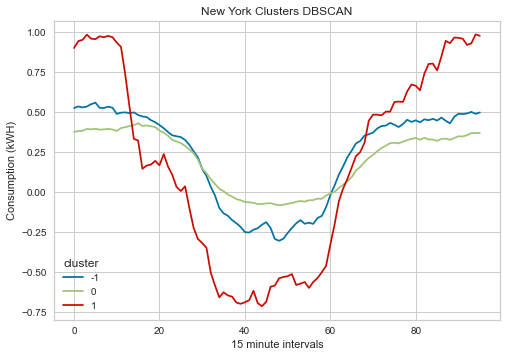

In [144]:
pcaed.groupby('cluster').mean().T[:-1].plot(kind = 'line')
plt.title('New York Clusters DBSCAN')
plt.xlabel('15 minute intervals')
plt.ylabel('Consumption (kWH)');

<AxesSubplot:>

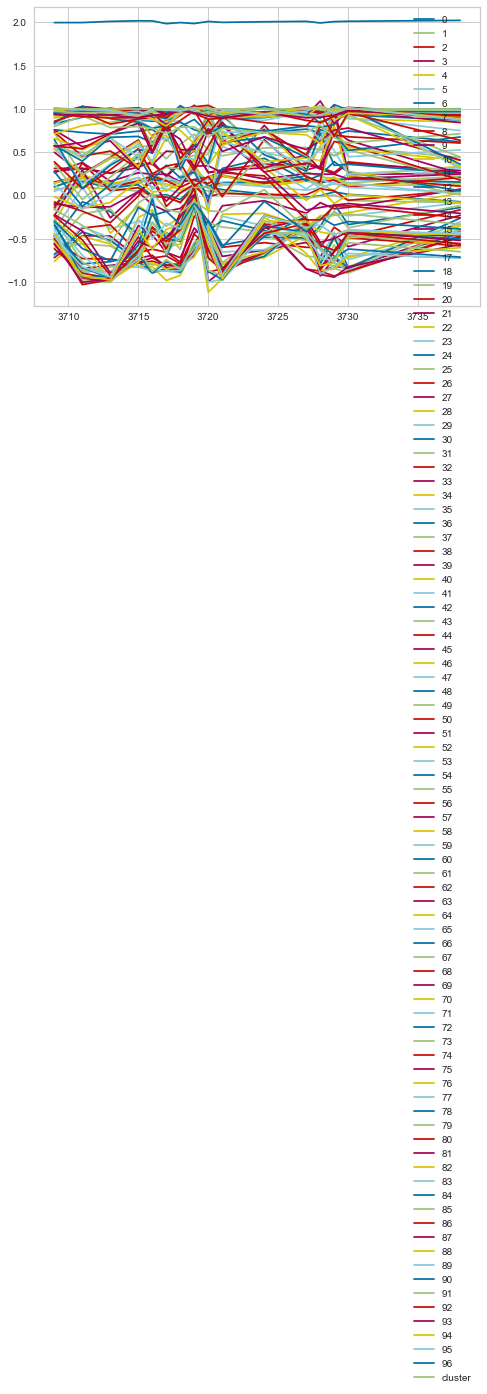

In [141]:
pcaed[pcaed['cluster'] == 1].plot(kind = 'line')